# Car PID Control

In this example, we are going to use a evolutionary algorithm to tune PID controllers.

The controllers will drive a car in an OpenAI Gym, let's start by installing the environment.

In [13]:
import evolvepy as ep
import numpy as np
import matplotlib.pyplot as plt

# Evaluator

In many applications, evaluating an individual can be a slow process. We can speed up this process by evaluating them in parallel. To do this, you need to define a class inheriting from **ProcessFitnessFunction**, which will act as a cost function. It has two methods that need to be defined:

- setup: will prepare the evaluator. Useful for performing costly processes that need to be done once to evaluate all individuals.
- evaluate: receives the individuals and returns the scores for each of them.

As Jupyter Notebook doesn't handle multiprocessing well, some classes are defined in the ["car_racing_utils.py"](car_racing_utils.py) file. A short description of the components in this file:

- PID class: a simple PID control implementation.
- compute_long_error: computes the longitudinal error, the difference between the velocity of the car and the desired velocity. As the observation of the environment only provides an image of it, this function "cheats" by accessing some other elements of it, since extracting the car's speed from the image would be more complex and is not the objective of this example.
- compute_lat_error: computes the lateral error, how far out of the center of the track the car is. Use the observation image, and check how far the car is from the edges, normalized between -0.5 and 0.5 (left-right edge)
- CarRacingEvaluator class: a ProcessFitnessFunction, initializes the environment once in the setup, and evaluates the individual by instantiating the lateral and longitudinal controllers and running the environment until its end. The individual's score is the sum of all rewards.

Once we have the cost class defined, we can instantiate the evaluator:

In [ ]:
from car_racing_utils import CarRacingEvaluator
evaluator = ep.evaluator.ProcessEvaluator(CarRacingEvaluator)

Another common problem in real environments is evaluation noise. With each assessment, the individual's score may vary, particularly when an individual is very lucky for the setting of the environment. In this case, one possible approach is to assess the same individual multiple times and average the scores. Let's do this using a MultipleEvaluation.

In [2]:
multiple_evaluation = ep.evaluator.MultipleEvaluation(evaluator, # The evaluator
                                                    n_evaluation=10, # How many times to evaluate the same individual
                                                     agregator=np.mean, # How to aggregate an individual's scores
                                                     discard_max=True, discard_min=True # Discards the lowest and highest score
                                                     )

Finally, to further accelerate evolution, we can use a fitness cache. It will store each individual's fitness, and retrieve it if they are assessed again. We can specify how many decimal places of genes we are considering when comparing two individuals.

In [ ]:
cache = ep.evaluator.FitnessCache(multiple_evaluation, max_decimals=5)

Both FitnessCache and MultipleEvaluation are evaluation stages, meaning they can act as evaluators, receiving one another to change their behavior.

# Generator

Let's define a simple generator with elitism. Our individuals will have a chromosome with 6 genes, each representing one of the constants (kp, ki, kd) of the two controllers (longitudinal and lateral).

In [3]:
descriptor = ep.generator.Descriptor(6, (0.0, 5.0))

In [4]:
from evolvepy import generator

n_individual = 50

first_layer = generator.Layer()

combine = generator.CombineLayer(generator.selection.tournament, generator.crossover.one_point)
mutation = generator.mutation.NumericMutationLayer(generator.mutation.sum_mutation, 1.0, 0.2, (-1.0, 1.0))
filter1 = generator.FilterFirsts(int(np.floor(0.95*n_individual)))
first_layer.next = combine
combine.next = mutation
mutation.next = filter1

sort = generator.Sort()
filter2 = generator.FilterFirsts(int(np.ceil(0.05*n_individual)))
first_layer.next = sort
sort.next = filter2

concatenate = generator.Concatenate()
filter1.next = concatenate
filter2.next = concatenate

gen = generator.Generator(descriptor=descriptor, first_layer=first_layer, last_layer=concatenate)

# Run and Results

Let's evolve our population and see the results

In [ ]:
evolver = ep.Evolver(gen, cache, n_individual)
hist, last_population = evolver.evolve(50)

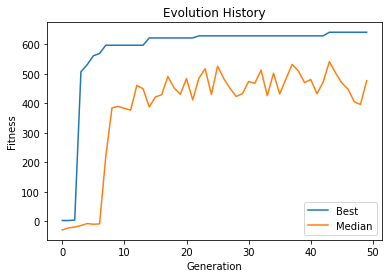

In [58]:
plt.plot(np.max(hist, axis=1))
plt.plot(np.median(hist, axis=1))

plt.legend(["Best", "Median"])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Evolution History")
plt.show()

By looking at fitness history, we can see how the best individual improved over time, with the rest of the population following along.

![Evolution History](CarPIDControl-Figure1.jpg)

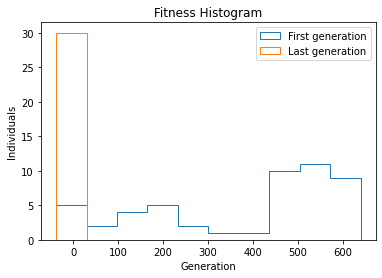

In [59]:
_, bins, _ = plt.hist(hist[-1], histtype="step")
plt.hist(hist[0], bins, histtype="step")

plt.legend(["First generation", "Last generation"])
plt.xlabel("Generation")
plt.ylabel("Individuals")
plt.title("Fitness Histogram")
plt.show()

The fitness histogram of the first and last generations shows that the population was converging to a better region as the generations passed.

![Evolution History](CarPIDControl-Figure2.jpg)

We can even save a video of our best individual:

In [12]:
best = last_population[np.argmax(hist[-1])]

test_evaluator = CarRacingEvaluator(save=True)
test_evaluator(best.ravel())

C:\Python38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Não é possível alterar o modo de thread depois de o mesmo estar definido
  warnings.warn(str(err))


625.2797202797096

A previously recorded result can be seen in the video below (click on the image to go to the video).

[![Evolution History](CarPIDControl-Figure3.png)](https://www.youtube.com/watch?v=7NaK_CaXaeo)

It is important to emphasize that the performance of the optimization depends a lot on the way the evaluation is defined. Comparing an evolved population as it is on this notebook with an evolved one with only 3 ratings and only 1 generation cache, we can see how noise hinders the evolution process:

![Run Comparison](CarPIDControl-Figure4.png)

Finally, a complete log of all data can be seen in [Weights and Biases](https://wandb.ai/eltoncn/EvolvePy%20Example/runs/2880i6ay?workspace=user-eltoncn).